# Repa

## Environment configuration

In [3]:
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"  # Set the segmentation_models framework
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Do not use GPU

## Imports

In [4]:
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from tqdm import tqdm

import segmentation_models as sm
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import random
import glob
import cv2

2024-12-01 19:39:25.141933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733078365.252125  877247 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733078365.284502  877247 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 19:39:25.598871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [5]:
tf.config.list_physical_devices("GPU")

2024-12-01 19:39:28.970232: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-01 19:39:28.970273: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: anonymous
2024-12-01 19:39:28.970284: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: anonymous
2024-12-01 19:39:28.970470: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2024-12-01 19:39:28.970490: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2024-12-01 19:39:28.970496: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1


[]

## Define constants

In [6]:
# Data
DATA_X: str = "x-sliced"
DATA_Y: str = "y-sliced"
DATA_EMPTY_SKIP: float = 0.2
DATA_VAL_SIZE: float = 0.2
DATA_TEST_SIZE: float = 0.2

# Training
BATCH_SIZE: int = 8
VERBOSE: bool = True

# Epochs
TRAIN_LR_FACTOR = 0.4
TRAIN_LR_PATIENCE = 30
TRAIN_STOP_PATIENCE = 80
TRAIN_LENGTH = 200

TRAIN_METRICS: dict[str, str | sm.base.objects.Metric] = {
    "accuracy": "accuracy",
    "dice_loss": sm.losses.dice_loss,
    "precision": sm.metrics.precision,
    "recall": sm.metrics.recall,
    "f1-score": sm.metrics.f1_score,
    "f2-score": sm.metrics.f2_score
}
TRAIN_METRIC_MONITOR: str = "val_loss"

MODEL_NAME: str = "model2.keras"

# To make graphs pretty
sns.set_theme()

In [7]:
x, y = [], []

for i in tqdm(glob.glob(f"{DATA_X}/*.png")):
    # Source data are not randomized
    random_pos = random.randint(0, len(x))

    # Format the label in accordance
    label = cv2.imread(i.replace(DATA_X, DATA_Y), 0)
    label = [(label == v) for v in [0, 255]]
    label = np.stack(label, axis=-1)

    # Skip some images without annotations
    if label[:, :, 1].sum() == 0:
      if random.random() < 1 - DATA_EMPTY_SKIP:
        continue

    # Save the images
    x.insert(random_pos, cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB))
    y.insert(random_pos, label)

100%|██████████| 1683/1683 [00:06<00:00, 270.34it/s]


## Prepare data

In [9]:
# Segmentation model requires float32
x = np.array(x, dtype="float32")
y = np.array(y, dtype="float32")

# Split data into train, validation and test
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=DATA_VAL_SIZE + DATA_TEST_SIZE)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=DATA_TEST_SIZE / (DATA_VAL_SIZE + DATA_TEST_SIZE))

# Clean RAM
del x
del y
del x_val_test
del y_val_test

# Sanity check
x_train.shape, x_val.shape, x_test.shape

((248, 512, 512, 3), (83, 512, 512, 3), (83, 512, 512, 3))

In [10]:
# Enforce data to be saved in RAM, not in VRAM
with tf.device("CPU"):
    ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

2024-12-01 19:39:53.812828: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 780140544 exceeds 10% of free system memory.
2024-12-01 19:39:55.144738: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 520093696 exceeds 10% of free system memory.
2024-12-01 19:39:56.003851: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 261095424 exceeds 10% of free system memory.


## Prepare model

In [11]:
# Create model
model = sm.Unet("seresnet18", classes=2, encoder_weights=None, input_shape=x_train[0].shape)
model.compile("Adam", sm.losses.DiceLoss(), metrics=list(TRAIN_METRICS.values()))

In [12]:
# Load model if already trained
model.load_weights(MODEL_NAME)

/home/tadeas/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 246 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Trian model

In [24]:
# Training callbacks
c_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=TRAIN_METRIC_MONITOR, factor=TRAIN_LR_FACTOR, patience=TRAIN_LR_PATIENCE, verbose=VERBOSE)
c_checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=TRAIN_METRIC_MONITOR, verbose=VERBOSE, save_best_only=True)
c_stop = tf.keras.callbacks.EarlyStopping(monitor=TRAIN_METRIC_MONITOR, patience=TRAIN_STOP_PATIENCE, verbose=VERBOSE)

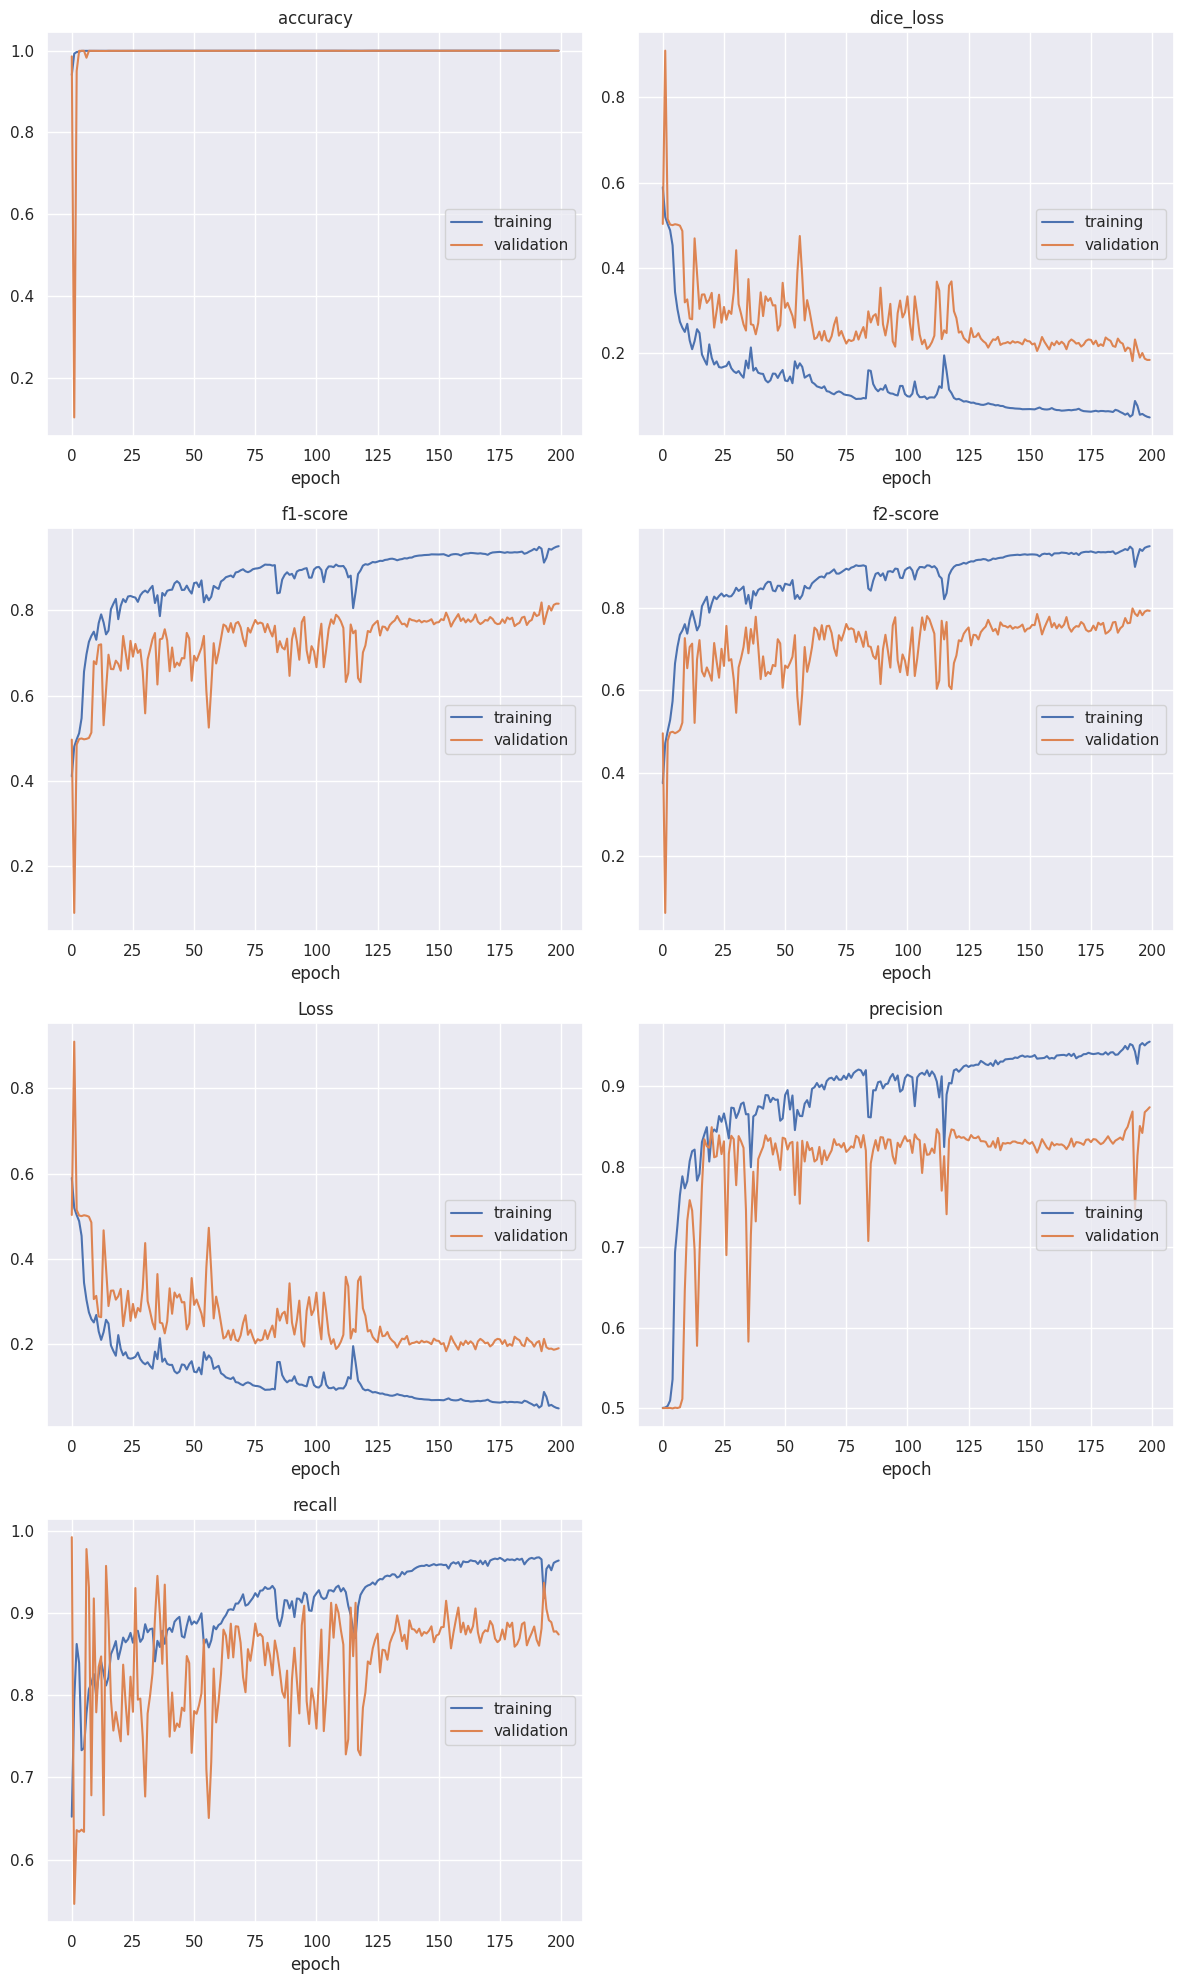

accuracy
	training         	 (min:    0.940, max:    1.000, cur:    1.000)
	validation       	 (min:    0.103, max:    1.000, cur:    1.000)
dice_loss
	training         	 (min:    0.049, max:    0.589, cur:    0.049)
	validation       	 (min:    0.181, max:    0.909, cur:    0.184)
f1-score
	training         	 (min:    0.411, max:    0.951, cur:    0.951)
	validation       	 (min:    0.091, max:    0.819, cur:    0.816)
f2-score
	training         	 (min:    0.376, max:    0.948, cur:    0.948)
	validation       	 (min:    0.062, max:    0.798, cur:    0.792)
Loss
	training         	 (min:    0.049, max:    0.590, cur:    0.049)
	validation       	 (min:    0.183, max:    0.909, cur:    0.190)
precision
	training         	 (min:    0.500, max:    0.956, cur:    0.956)
	validation       	 (min:    0.500, max:    0.874, cur:    0.874)
recall
	training         	 (min:    0.652, max:    0.968, cur:    0.964)
	validation       	 (min:    0.546, max:    0.992, cur:    0.874)

Epoch 200: val_l

In [25]:
# Train model
history = model.fit(ds_train, validation_data=ds_val, epochs=TRAIN_LENGTH, callbacks=[PlotLossesKeras(), c_reduce_lr, c_checkpoint, c_stop])

## Evaluate model

In [13]:
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

2024-12-01 19:40:06.777977: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 261095424 exceeds 10% of free system memory.
2024-12-01 19:40:09.429663: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


/tmp/ipykernel_877247/2511488119.py:17: RuntimeWarning: divide by zero encountered in log
  ax[3].imshow(np.log(y_pred[n, :, :, 1]), cmap="gray")


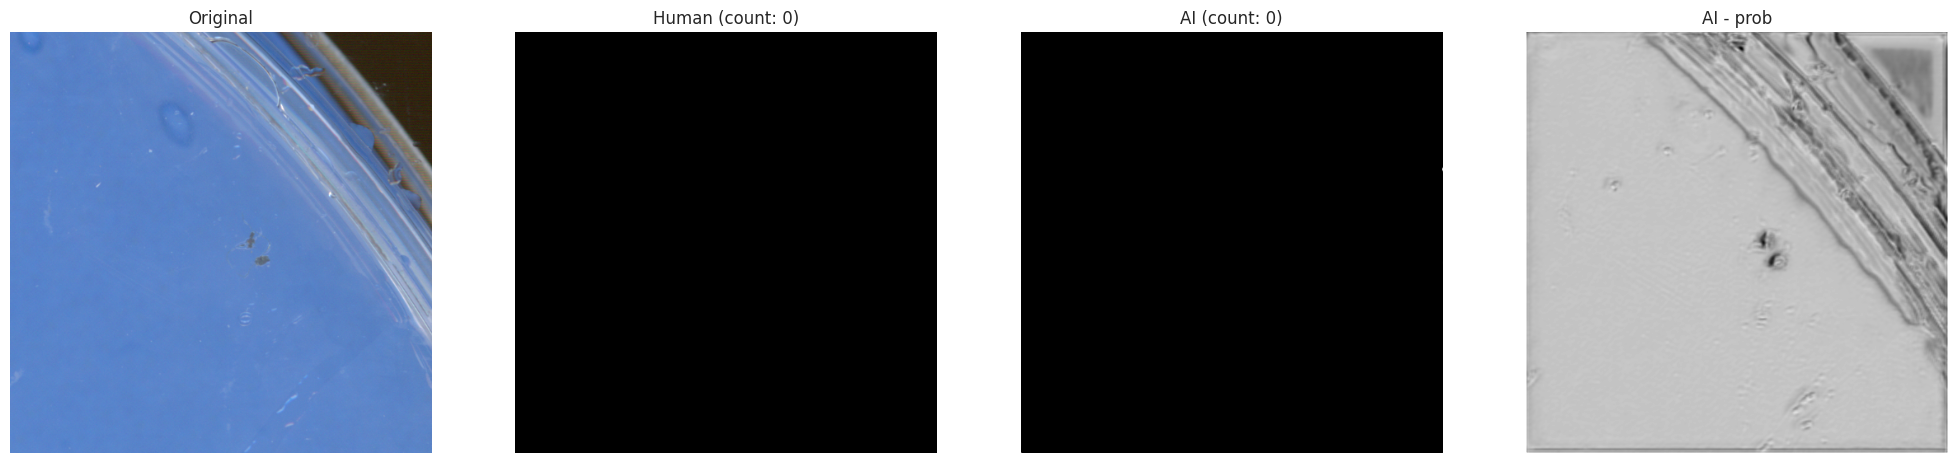

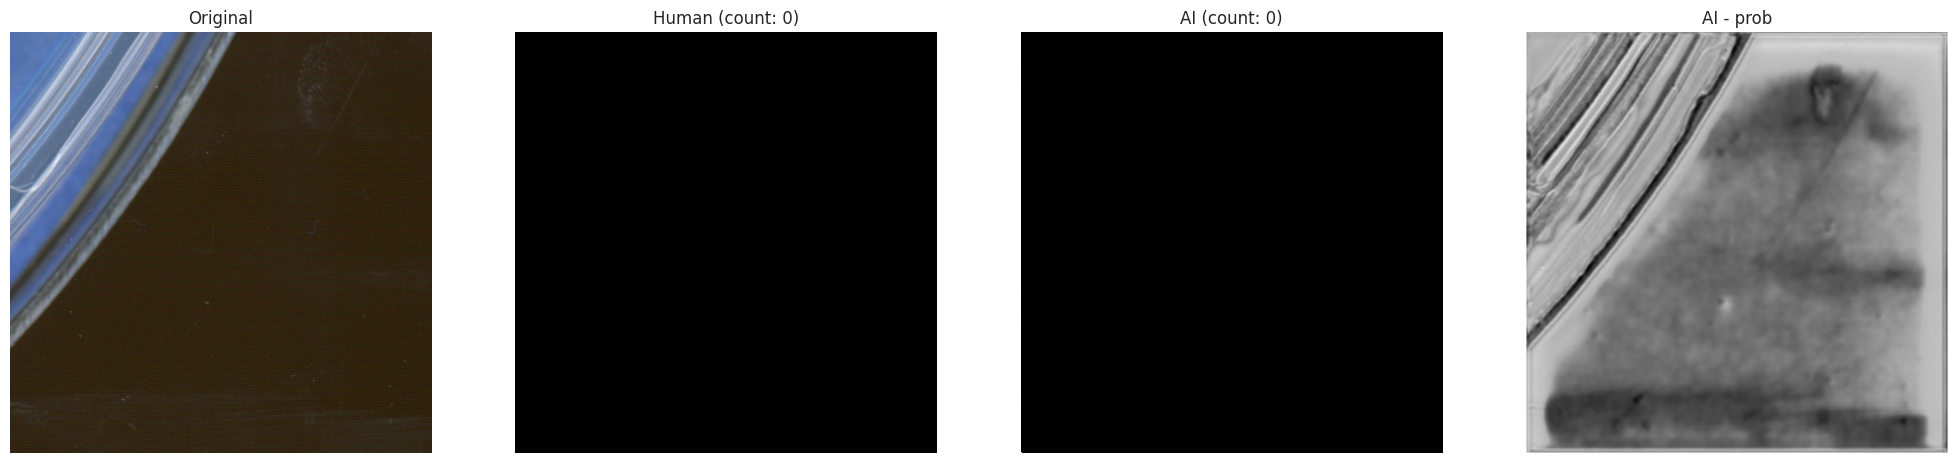

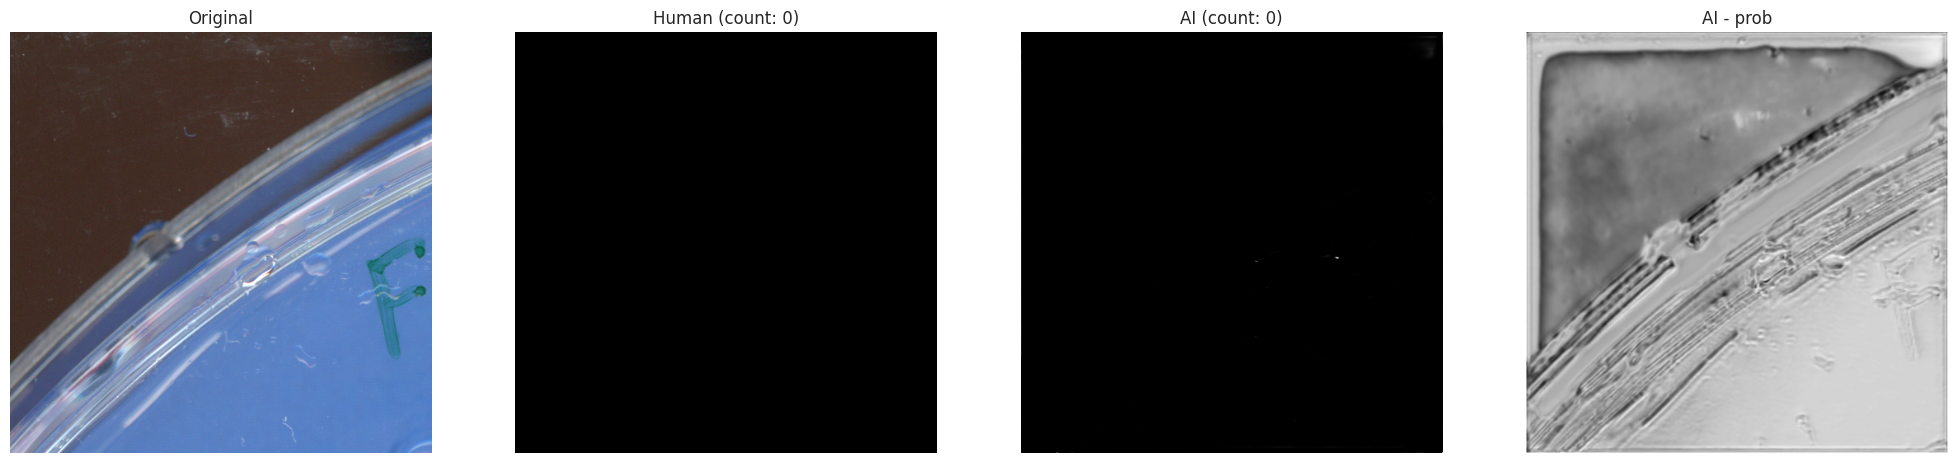

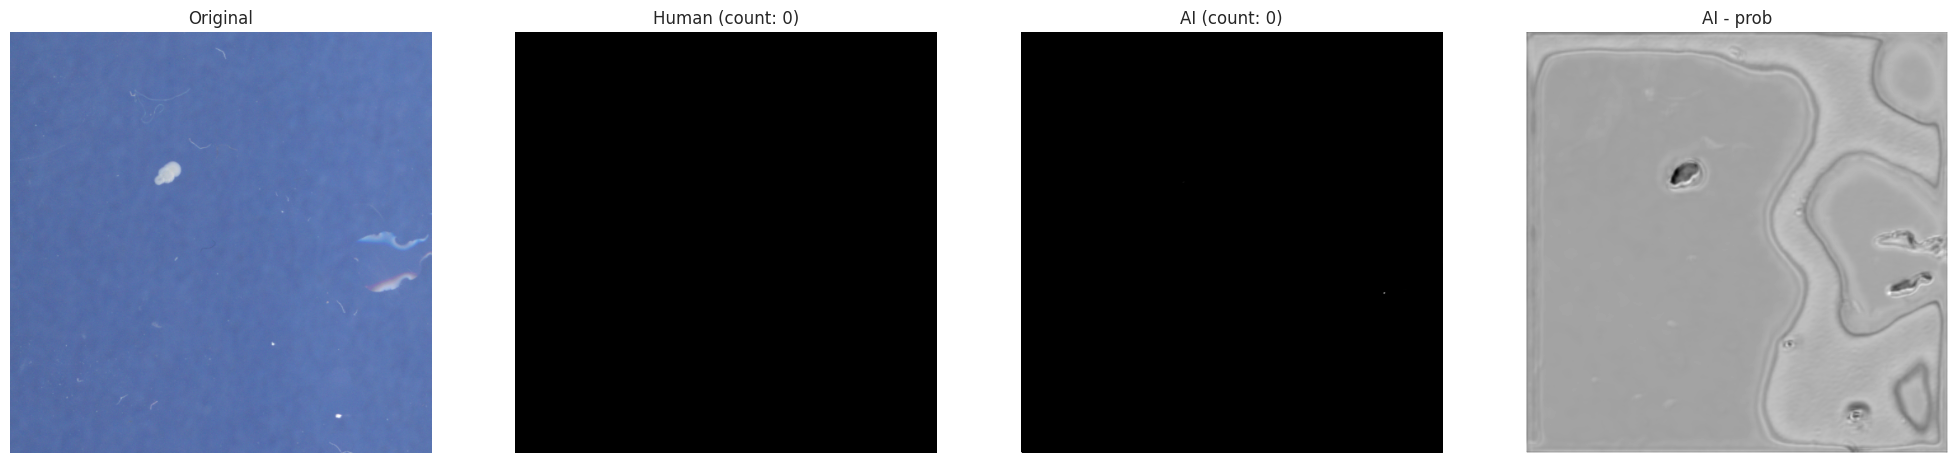

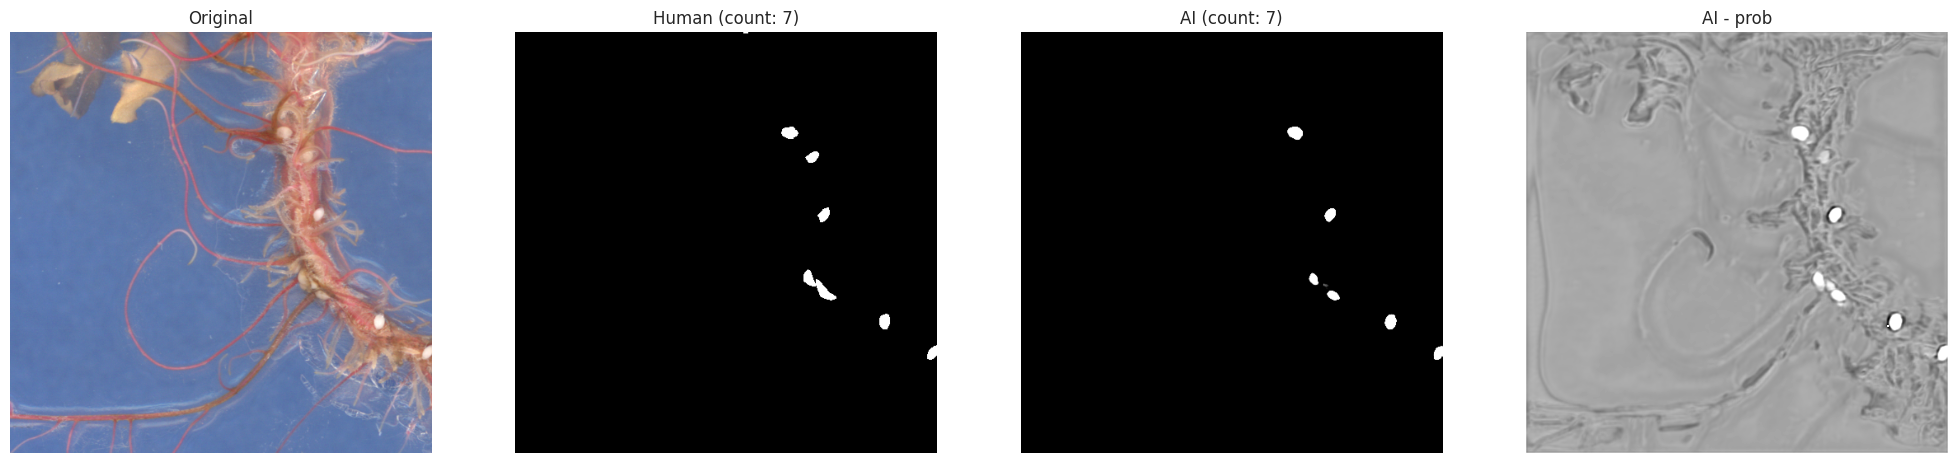

In [21]:
THRESHOLD_FOR_COUNTING = 0.1

for n in range(len(y_pred)):
    _, ax = plt.subplots(1, 4, figsize=(25, 12))

    for a in ax:
        a.grid(None)
        a.axis("off")

    # Count objects in the test and prediction
    contours_test, _ = cv2.findContours((y_test[n, :, :, 1] >= THRESHOLD_FOR_COUNTING).astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_pred, _ = cv2.findContours((y_pred[n, :, :, 1] >= THRESHOLD_FOR_COUNTING).astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ax[0].imshow(x_test[n, :, :].astype("uint8"))
    ax[1].imshow(y_test[n, :, :, 1], cmap="gray")
    ax[2].imshow(y_pred[n, :, :, 1], cmap="gray")
    ax[3].imshow(np.log(y_pred[n, :, :, 1]), cmap="gray")

    ax[0].set_title("Original")
    ax[1].set_title(f"Human (count: {len(contours_test)})")
    ax[2].set_title(f"AI (count: {len(contours_pred)})")
    ax[3].set_title("AI - prob")